# Factorial HMM with Gaussian emissions

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lindermanlab/ssm-jax-refactor/blob/main/notebooks/factorial-hmm.ipynb)

This notebook showcases a simple factorial hidden Markov model where the latent state factors into multiple groups, $z_t = (z_{t1}, z_{t2}, \ldots, z_{tG}) \in [K_1] \times [K_2] \times \cdots \times [K_G]$ where $G$ denotes the number of groups, $K_g$ is the number of discrete states $z_{tg}$ can take on, and $[K_g]$ is shorthand for the set $\{1,\ldots, K_g\}$. 

The factorial HMM assumes that each group transitions independently, but that they are all linked in the likelihood $p(x_t \mid z_t)$. The joint probability is,
\begin{align}
p(z_{1:T}, x_{1:T}) &= 
\left[ \prod_{g=1}^G p(z_{1g}) \right] 
\left[ \prod_{t=2}^T \prod_{g=1}^G p(z_{tg} \mid z_{t-1,g}) \right]
\left[ \prod_{t=1}^T p(x_t \mid z_{t}) \right]
\end{align}
Here, we consider a simple model where the emissions are scalar Gaussians and the likelihood is,
\begin{align}
p(x_t \mid z_t) &= \mathcal{N}\left(x_t \,\Big|\, \sum_{g=1}^G \mu_{g,z_{tg}}, \sigma^2 \right) 
\end{align}
For example, suppose you observe the aggregate power usage of a home. At any point in time, the expected power reading may be the sum of power usages for each appliace that is on at that time. To model this setting, let $G$ denotes the number of appliances (groups), $z_{tg} \in \{0,1\}$ indicate whether that appliance is on or off, and then let $\mu_{g,1}$ denote the average usage when that appliace is on, and set $\mu_{g,0} = 0$.



In [11]:
try:
    import ssm
except:
    import os
    from getpass import getpass
    user = getpass('GitHub user')
    password = getpass('GitHub token')
    os.environ['GITHUB_AUTH'] = user + ':' + password
    !pip install git+https://$GITHUB_AUTH@github.com/lindermanlab/ssm-jax-refactor.git -qqq
    del user, password
    import ssm

In [12]:
import jax.numpy as np
import jax.random as jr
import jax.scipy.special as spsp
from jax import value_and_grad, vmap

import matplotlib.pyplot as plt

from ssm.factorial_hmm.posterior import _factorial_hmm_log_normalizer
from ssm.hmm.posterior import hmm_log_normalizer

In [13]:
from ssm.factorial_hmm.models import NormalFactorialHMM

num_states = (2, 2, 2)
factorial_hmm = NormalFactorialHMM(num_states=num_states, seed=jr.PRNGKey(0))

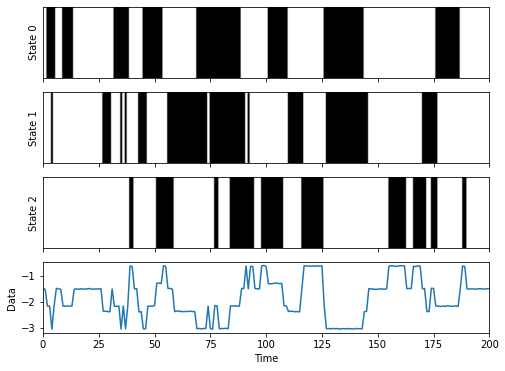

In [14]:
states, data = factorial_hmm.sample(jr.PRNGKey(0), 10000)

# Plot the states and data
fig, axs = plt.subplots(len(num_states) + 1, 1, figsize=(8, 6), sharex=True)
for i in range(len(num_states)):
    axs[i].imshow(states[i][None, :], cmap="Greys", aspect="auto")
    axs[i].set_ylabel("State {}".format(i))
    axs[i].set_yticks([])
axs[-1].plot(data)
axs[-1].set_ylabel("Data")
axs[-1].set_xlabel("Time")
axs[-1].set_xlim(0, 200)
plt.show()

# Fit the data with another factorial HMM

Initializing...
Done.


/Users/collinschlager/Code/ssm-jax-refactor/ssm/factorial_hmm/base.py:41: UserWarning: FactorialHMM.initialize() is not implemented!
  warnings.warn(UserWarning("FactorialHMM.initialize() is not implemented!"))


  0%|          | 0/100 [00:00<?, ?it/s]

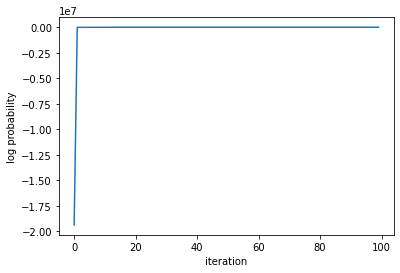

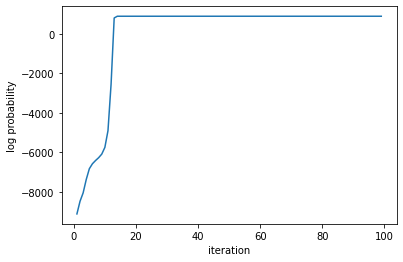

In [21]:
test_factorial_hmm = NormalFactorialHMM(num_states, seed=jr.PRNGKey(3))  # <-- different seed
lps, _, posteriors = test_factorial_hmm.fit(data, tol=-1)

plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log probability")

plt.figure()
plt.plot(np.arange(1, len(lps)), lps[1:])
plt.xlabel("iteration")
plt.ylabel("log probability")
plt.show()

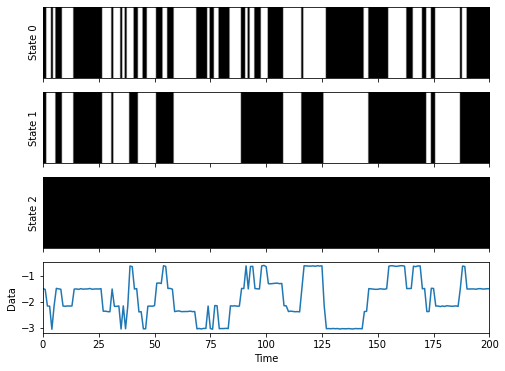

In [22]:
# compute marginal probabilities for each state
expected_states = posteriors.expected_states[0]
marginals = []
for j in range(len(num_states)):
    axes = tuple(np.concatenate([np.arange(j), np.arange(j+1, len(num_states))]) + 1)
    marginals.append(np.sum(expected_states, axis=axes))

# Plot the states and data
fig, axs = plt.subplots(len(num_states) + 1, 1, figsize=(8, 6), sharex=True)
for i in range(len(num_states)):
    axs[i].imshow(marginals[i][None, :, 1], cmap="Greys", aspect="auto", vmin=0, vmax=1)
    axs[i].set_ylabel("State {}".format(i))
    axs[i].set_yticks([])
    
axs[-1].plot(data)
axs[-1].set_ylabel("Data")
axs[-1].set_xlabel("Time")
axs[-1].set_xlim(0, 200)
plt.show()

In [23]:
print(factorial_hmm._emissions._distribution.loc)
print(test_factorial_hmm._emissions._distribution.loc)

[[[-1.5112934  -0.63249874]
  [-2.3792994  -1.5005047 ]]

 [[-2.1733613  -1.2945665 ]
  [-3.041367   -2.1625724 ]]]
[[[ 1.0968707  -2.2346435 ]
  [ 2.6978102  -0.63370377]]

 [[ 0.2894715  -3.0420425 ]
  [ 1.8904111  -1.441103  ]]]
